# IBM AI Workflow Specialization Capstone #
## Assimilating The Business Opportunity And Articulate Testable Hypotheses ##

The management at AAVAIL wants to know whether their alternative approaches to generating revenue have ultimately been successful or not. They have a sizable amount of data over a reasonable amount of time, but aren't quite sure what to make of said data. They want a predictive model that will be able to predict the revenue for the following month, and additionally they want the ability for the service to predict projected revenue for specific countries in the dataset. 

The results are expected to be more accurate than the current model that they are using. 

### Potential hypotheses ###

There are a number of potential hypotheses that could be tested. It ultimately depends on the quality and complexity of the data that was collected. 
<ul>
<li>The amount of revenue generated for each month can be modelled as a Bayesian model, where the revenue for each month is dependent on the revenue of the previous month(s) and several other factors.</li>
<li>Revenue per month can also be correlated with the amount of content streamed per each individual user and average time of engagement with content on the platform in the previous month(s).</li>
<li>Revenue per month can also be correlated with the average amount of unique content streamed per each individual user in each of the previous month(s).</li>
</ul>

### Data needed to address each hypothesis ###

Ultimately the data that we need to address each of the hypotheses are as follows:

<ul>
<li>For modelling the amount of revenue generated for each month, we need the time of each stream aggregated by month and the total amount of money spent per invoice per month.</li>
<li>Modelling the amount of content streamed per each individual user simply requires counting all of the entries in a database and grouping them by user_id.</li>
<li>Calculating the average time of engagement with content on the platform is highly dependent on the amount of data that we have available. A simple start and end times for each stream might suffice, but in the case where that data isn't available, a good fallback would be the length/runtime of each piece of content that the user purchased.</li>
<li>Calculating the average amount of unique content streamed per each individual user simply requires aggregating over the dataset and grouping by the content_id and the user_id.</li>
</ul>

## Data ingestion ##

In [1]:
%%writefile load_data.py
import json
import glob
import pandas as pd
def load_data(pathname):
#load data
    data = []
    for filename in glob.glob(f"{pathname}/*.json"):
        with open(filename, "r") as file:
            for line in file:
                entry = json.loads(line)
                data += entry
    df = pd.DataFrame(data)
    return df

Overwriting load_data.py


In [2]:
#do a bit of EDA on the data before we can 
import pandas as pd
import numpy as np
from load_data import load_data
DATA_DIR = "cs-train"
df = load_data(DATA_DIR)

There are several missing stream_ids even though there are two columns both with the name StreamID. While this isn't the end of the world, it does give pause as to see what other things are missing in the dataset. 

We are also missing quite a number of customer_ids as well, which isn't a bad thing since we can simply reconstruct the number of users based on each individual invoice. It is a big deal, however, in terms of the hypotheses I had proposed above.

In [3]:
print(df.columns)
print(len(df))
#get the number of columns where both stream id columns are empty
#we have all stream ids
num_stream_ids = len(df[(~df["stream_id"].isna())|(~df["StreamID"].isna())])
print(f"Entries with a proper stream id: {num_stream_ids}")
df["stream_id"] = df["stream_id"].fillna(df["StreamID"])
#we have the full price data for each purchase in the dataset
num_prices = len(df[(~df["total_price"].isna())|(~df["price"].isna())])
print(f"Entries with a proper price: {num_prices}")
df["total_price"] = df["total_price"].fillna(df["price"])
#how much of times_viewed are we missing?
num_times_viewed = len(df[(~df["times_viewed"].isna())|(~df["TimesViewed"].isna())])
print(f"Entries with a proper times_viewed: {num_times_viewed}")
df["times_viewed"] = df["times_viewed"].fillna(df["TimesViewed"])

assert len(df[df["stream_id"].isna()]) == 0
assert len(df[df["total_price"].isna()]) == 0
assert len(df[df["times_viewed"].isna()]) == 0
print("No empty fields in columns stream_id, total_price, times_viewed")

Index(['country', 'customer_id', 'invoice', 'price', 'stream_id',
       'times_viewed', 'year', 'month', 'day', 'total_price', 'StreamID',
       'TimesViewed'],
      dtype='object')
815011
Entries with a proper stream id: 815011
Entries with a proper price: 815011
Entries with a proper times_viewed: 815011
No empty fields in columns stream_id, total_price, times_viewed


In [4]:
#Now we take a look at the customer id data
missing = df[df["customer_id"].isna()]
print(missing.head(5))
print(len(missing))
invoices = missing[missing["invoice"]=="489597"]["customer_id"].unique()
print(invoices)

          country  customer_id invoice  price stream_id  times_viewed  year  \
1  United Kingdom          NaN  489597   8.65     22130           1.0  2017   
2  United Kingdom          NaN  489597   1.70     22132           6.0  2017   
3  United Kingdom          NaN  489597   1.70     22133           4.0  2017   
4  United Kingdom          NaN  489597   0.87     22134           1.0  2017   
5  United Kingdom          NaN  489597   0.87     22135           1.0  2017   

  month day  total_price StreamID  TimesViewed  
1    11  28         8.65      NaN          NaN  
2    11  28         1.70      NaN          NaN  
3    11  28         1.70      NaN          NaN  
4    11  28         0.87      NaN          NaN  
5    11  28         0.87      NaN          NaN  
189762
[nan]


In [5]:
#merge the day, month and year fields into one column
df["date"] = pd.to_datetime(df[["day", "month", "year"]])
print(df.head(5))

          country  customer_id invoice  price stream_id  times_viewed  year  \
0  United Kingdom      13085.0  489434   6.95     85048          12.0  2017   
1  United Kingdom          NaN  489597   8.65     22130           1.0  2017   
2  United Kingdom          NaN  489597   1.70     22132           6.0  2017   
3  United Kingdom          NaN  489597   1.70     22133           4.0  2017   
4  United Kingdom          NaN  489597   0.87     22134           1.0  2017   

  month day  total_price StreamID  TimesViewed       date  
0    11  28         6.95      NaN          NaN 2017-11-28  
1    11  28         8.65      NaN          NaN 2017-11-28  
2    11  28         1.70      NaN          NaN 2017-11-28  
3    11  28         1.70      NaN          NaN 2017-11-28  
4    11  28         0.87      NaN          NaN 2017-11-28  


In [6]:
#now let's create a new clean dataframe with all of the relevant information
df = df.drop(["StreamID", "TimesViewed", "price", "year", "month", "day"], axis=1)
print(df.head(5))
print(len(df))

          country  customer_id invoice stream_id  times_viewed  total_price  \
0  United Kingdom      13085.0  489434     85048          12.0         6.95   
1  United Kingdom          NaN  489597     22130           1.0         8.65   
2  United Kingdom          NaN  489597     22132           6.0         1.70   
3  United Kingdom          NaN  489597     22133           4.0         1.70   
4  United Kingdom          NaN  489597     22134           1.0         0.87   

        date  
0 2017-11-28  
1 2017-11-28  
2 2017-11-28  
3 2017-11-28  
4 2017-11-28  
815011


In [7]:
#let's look at a particular user in the dataFrame
print(df[df["customer_id"]==13085]["stream_id"])
print(df[df["customer_id"]==13085].groupby(["date"]).count())

0          85048
2142      79323P
2143      79323W
2144       22041
2145       21232
           ...  
776361     22617
776362     20750
776363     21791
776398     21889
776399     22192
Name: stream_id, Length: 92, dtype: object
            country  customer_id  invoice  stream_id  times_viewed  \
date                                                                 
2017-11-28       12           12       12         12            12   
2017-11-30       14           14       14         14            14   
2018-01-26       36           36       36         36            36   
2018-10-12        1            1        1          1             1   
2019-02-14       13           13       13         13            13   
2019-04-25        7            7        7          7             7   
2019-07-02        9            9        9          9             9   

            total_price  
date                     
2017-11-28           12  
2017-11-30           14  
2018-01-26           36  
2018-10-1

In [33]:
#sanity check real quick
print(len(df["stream_id"].unique()))

5007


In [8]:
#and now we aggregate the data and group by country and summary statistics
#first need to create a new column that has the total revenue generated per each individual stream
df["total_revenue"] = df.apply(lambda x: x["total_price"]*x["times_viewed"], axis=1)
print(df["total_revenue"])

0         83.40
1          8.65
2         10.20
3          6.80
4          0.87
          ...  
815006    10.20
815007    15.60
815008     9.96
815009    14.85
815010    19.80
Name: total_revenue, Length: 815011, dtype: float64


            total_revenue
date                     
2017-11-28       41623.51
2017-11-29       37442.78
2017-11-30       40755.15
2017-12-01       30658.16
2017-12-02        8238.29


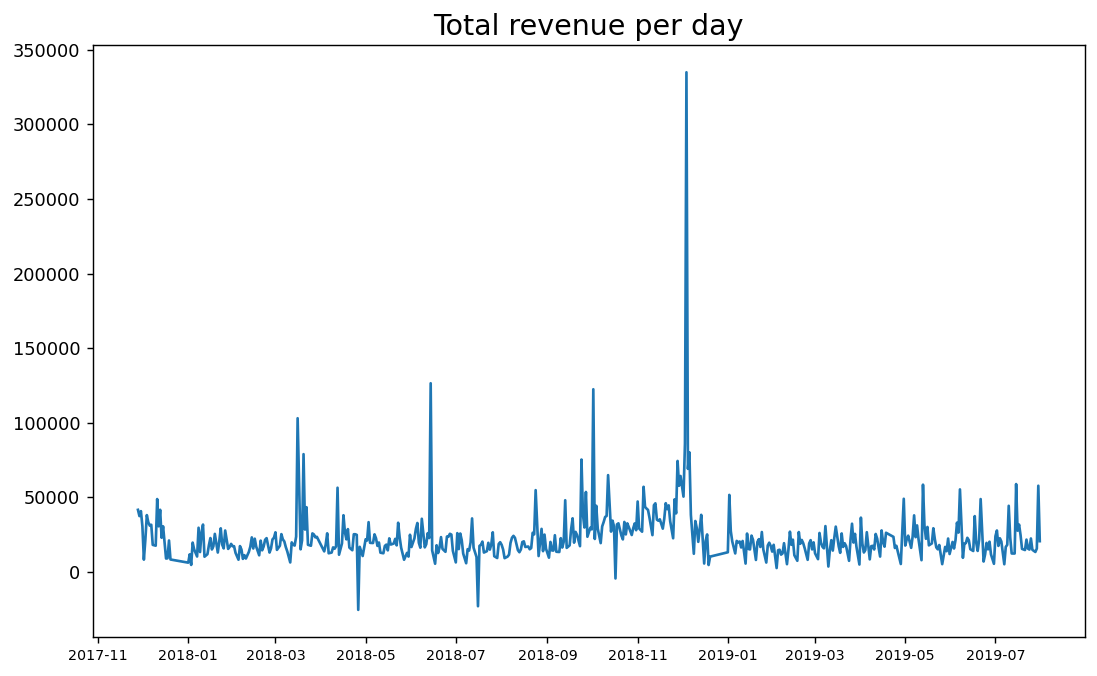

In [18]:
#aggregate each day based on the total revenue
import matplotlib.pyplot as plt

overview = df[["date", "total_revenue"]].groupby(["date"]).sum()
overview = overview.sort_values(by=["date"])
print(overview.head(5))

fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(overview.index, overview["total_revenue"])
plt.title("Total revenue per day", fontdict={"fontsize": 16})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

            invoice
date               
2017-11-28      166
2017-11-29      133
2017-11-30      150
2017-12-01      107
2017-12-02       32


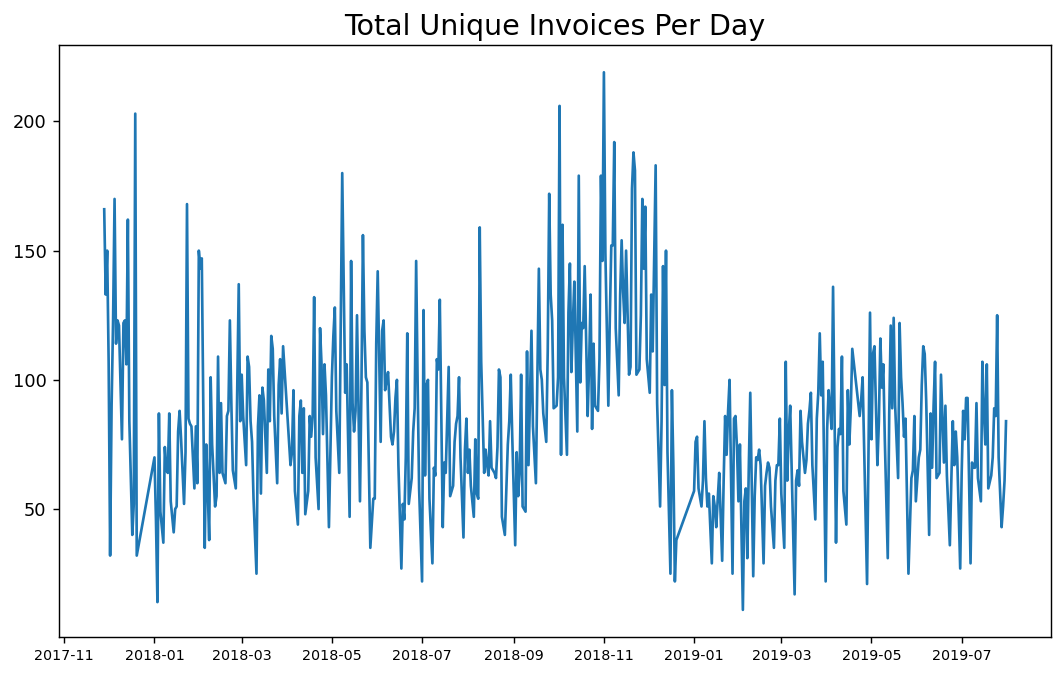

In [34]:
#aggregate each day based on the total number of invoices accounted for
count_invoices = df[["date", "invoice"]].drop_duplicates().groupby(["date"]).count().sort_values(by="date")
print(count_invoices.head(5))

fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(count_invoices.index, count_invoices["invoice"])
plt.title("Total Unique Invoices Per Day", fontdict={"fontsize": 16})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

            stream_id
date                 
2017-11-28       1345
2017-11-29       1397
2017-11-30       1335
2017-12-01       1256
2017-12-02        287


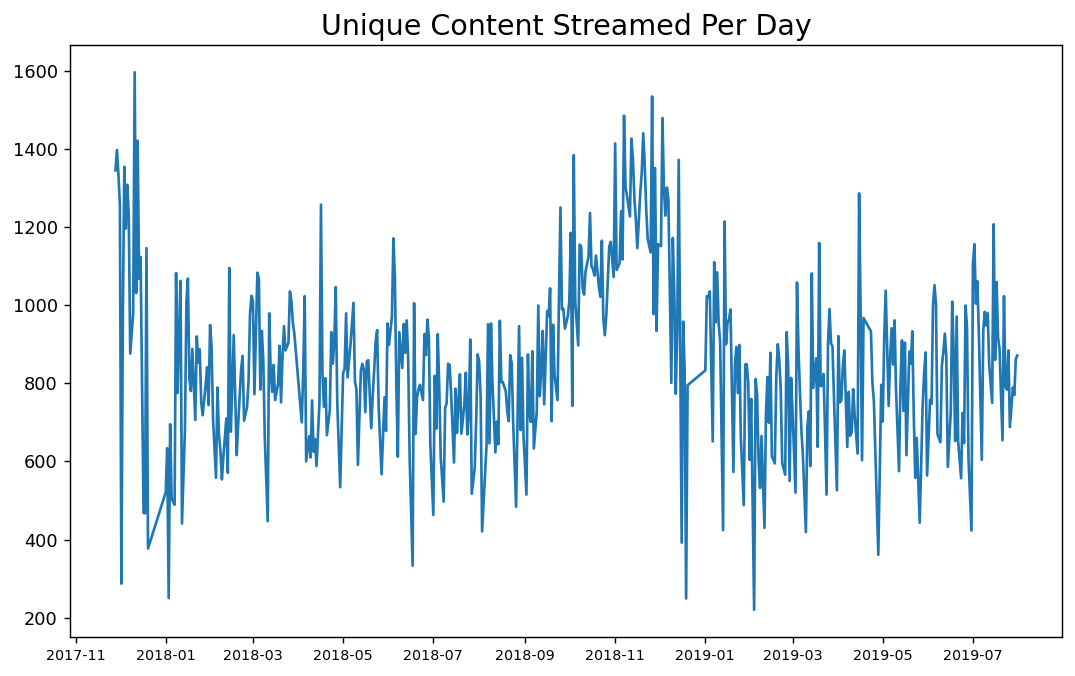

In [35]:
#let's see whether or not the *number* of unique items (stream_ids) on the streaming platform changed over time as well
#it's an assumption to think that consumers will engage will all content on the platform at any one given time
#but the sample size is indicative of how big the population is as well
count_content = df[["date", "stream_id"]].drop_duplicates().groupby(["date"]).count().sort_values(by="date")
print(count_content.head(5))

fig = plt.figure(dpi=128, figsize=(10,6))
plt.plot(count_content.index, count_content["stream_id"])
plt.title("Unique Content Streamed Per Day", fontdict={"fontsize": 16})
plt.tick_params(axis='x', which='major', labelsize=8)
plt.show()

There are several interesting conclusions that we can draw from these graphs.

1. The huge spike in revenue for the company around December of 2019 is also when there was a huge decline in both the number of unique content streamed per day and the number of unique invoices per day. Clearly, there might be other factors at work to determine the total revenue. 

2. There appears to be a strong correlation between the number of unique invoices per day and the amount of unique content streamed per day. This might be in part due to some colinearity, but it might be worth exploring more in the future. 

## Deciding which variables to use for the Bayesian model ##